In [54]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col,min,max,mean
import time
from pyspark.sql.functions import col, when, count, sum
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DoubleType, TimestampType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count, sum, min, max, mean,countDistinct
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import year, month, dayofmonth, hour, datediff, lit
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, max as spark_max, sum as spark_sum, count as spark_count, col, udf
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
import datetime
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum, max, datediff
from pyspark.sql import functions as F
from pyspark.sql.window import Window


In [47]:


schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("user_session", StringType(), True)
])


In [48]:


spark = SparkSession.builder \
    .appName("clustering") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "5g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()


In [49]:
octobre_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2019-Oct.csv", header=True, schema=schema)
novembre_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2019-Nov.csv", header=True, schema=schema)
decembre_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2019-Dec.csv", header=True, schema=schema)
janvier_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Jan.csv", header=True, schema=schema)
fevrier_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Feb.csv", header=True, schema=schema)
mars_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Mar.csv", header=True, schema=schema)
avril_df = spark.read.csv("/home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Apr.csv", header=True, schema=schema)

combined_df = (octobre_df
               .union(novembre_df)
               .union(decembre_df)
               .union(janvier_df)
               .union(fevrier_df)
               .union(mars_df)
               .union(avril_df))

In [50]:
filtered_df = combined_df.filter(col('user_id') == 513117637)
filtered_df.show()

+-------------------+----------+----------+-------------------+--------------------+-----+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-----+-------+---------+--------------------+
|2019-10-01 10:36:34|      view|   1005120|2053013555631882655|electronics.smart...|apple| 1181.5|513117637|9e57b3bc-ee27-49f...|
|2019-10-01 10:58:43|      view|   1005120|2053013555631882655|electronics.smart...|apple| 1181.5|513117637|9e57b3bc-ee27-49f...|
|2019-10-01 10:59:13|      view|   1005117|2053013555631882655|electronics.smart...|apple|1181.37|513117637|9e57b3bc-ee27-49f...|
|2019-10-01 11:00:36|      view|   1005117|2053013555631882655|electronics.smart...|apple|1181.37|513117637|9e57b3bc-ee27-49f...|
|2019-10-01 11:00:41|      view|   1005123|2053013555631882655|electronics.smart...|apple|

In [29]:
rfm_df=combined_df
rfm_df.show()

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 02:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 02:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 02:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 02:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 02:00:04|      view|   1004237|2053013555631882655|electr

In [49]:

def count_missing_values(df):

    missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
    return missing_values

def df_in_range(df, column_name, lower_bound, upper_bound):
    res = df.filter((col(column_name) >= lower_bound) & (col(column_name) <= upper_bound))
    return res

def count_values_in_range(df, column_name, lower_bound, upper_bound):
    filtered_df = df.filter((col(column_name) >= lower_bound) & (col(column_name) <= upper_bound))
    return filtered_df.count()
    
def count_zero_values(df, column_name):
    zero_count = df.filter(col(column_name) == 0).count()
    return zero_count
    
def count_specific_value(df, column_name, value):
    value_count = df.filter(col(column_name) == value).count()
    return value_count

In [51]:
rfm_df = combined_df.select("event_time", "event_type", "price", "user_id")
rfm_df.show()

+-------------------+----------+-------+---------+
|         event_time|event_type|  price|  user_id|
+-------------------+----------+-------+---------+
|2019-10-01 02:00:00|      view|  35.79|541312140|
|2019-10-01 02:00:00|      view|   33.2|554748717|
|2019-10-01 02:00:01|      view|  543.1|519107250|
|2019-10-01 02:00:01|      view| 251.74|550050854|
|2019-10-01 02:00:04|      view|1081.98|535871217|
|2019-10-01 02:00:05|      view| 908.62|512742880|
|2019-10-01 02:00:08|      view| 380.96|555447699|
|2019-10-01 02:00:08|      view|  41.16|550978835|
|2019-10-01 02:00:10|      view| 102.71|520571932|
|2019-10-01 02:00:11|      view| 566.01|537918940|
|2019-10-01 02:00:11|      view|  51.46|555158050|
|2019-10-01 02:00:11|      view| 900.64|530282093|
|2019-10-01 02:00:13|      view| 102.38|555444559|
|2019-10-01 02:00:15|      view|  35.79|541312140|
|2019-10-01 02:00:16|      view|  93.18|555446365|
|2019-10-01 02:00:17|      view| 357.79|513642368|
|2019-10-01 02:00:18|      view

In [52]:
rfm_df = rfm_df.filter(col("event_type") == "purchase")
rfm_df = rfm_df.dropna(subset=["event_time", "event_type","price", "user_id"])
rfm_df = rfm_df.dropDuplicates()
rfm_df = rfm_df.filter(rfm_df['price'] != 0)

In [21]:
count_missing_values(rfm_df).show()
count_zero_values(rfm_df,'price')
rfm_df.describe('price').show()

24/06/27 10:08:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 693346, 5273285d-9904-4643-b34d-d46b1e66ac78, , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 693346
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2019-Nov.csv
24/06/27 10:08:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 2-f130-47ef-ad86-bb0ddd5c3f2e, , , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 2-f130-47ef-ad86-bb0ddd5c3f2e
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Jan.csv
24/06/27 10:08:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 77520756, construction.tools.light, , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 77520756
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Feb.csv
24/06/27 10:08:42 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 07:50 UTC, 

+----------+----------+-----+-------+
|event_time|event_type|price|user_id|
+----------+----------+-----+-------+
|         0|         0|    0|      0|
+----------+----------+-----+-------+



24/06/27 10:09:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 693346, 5273285d-9904-4643-b34d-d46b1e66ac78, , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 693346
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2019-Nov.csv
24/06/27 10:09:34 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 2-f130-47ef-ad86-bb0ddd5c3f2e, , , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 2-f130-47ef-ad86-bb0ddd5c3f2e
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Jan.csv
24/06/27 10:09:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 77520756, construction.tools.light, , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 77520756
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Feb.csv
24/06/27 10:09:43 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 07:50 UTC, 

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|          3068307|
|   mean|300.0583586029945|
| stddev|336.8733498668554|
|    min|             0.13|
|    max|          2574.07|
+-------+-----------------+



In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum, max, datediff
from pyspark.sql import functions as F






rfm_df = rfm_df.withColumn("event_time", F.to_date(col("event_time")))


reference_date = rfm_df.agg(max("event_time")).collect()[0][0]


rfm_table = rfm_df.groupBy("user_id").agg(
    datediff(F.lit(reference_date), max("event_time")).alias("recency"),
    count("event_time").alias("frequency"),
    sum("price").alias("monetary")
)



24/06/27 13:40:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 693346, 5273285d-9904-4643-b34d-d46b1e66ac78, , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 693346
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2019-Nov.csv
24/06/27 13:40:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 2-f130-47ef-ad86-bb0ddd5c3f2e, , , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 2-f130-47ef-ad86-bb0ddd5c3f2e
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Jan.csv
24/06/27 13:40:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 77520756, construction.tools.light, , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 77520756
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Feb.csv
24/06/27 13:40:36 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 07:50 UTC, 

In [56]:




# Exemple de création du DataFrame rfm_df
# rfm_df = spark.read.option("header", True).csv("path/to/your/data.csv")

# Convertir la colonne event_time en date
rfm_df = rfm_df.withColumn("event_time", F.to_date(col("event_time")))

# Définir la date de référence
reference_date = rfm_df.agg(max("event_time")).collect()[0][0]

# Calculer les valeurs RFM
rfm_table = rfm_df.groupBy("user_id").agg(
    datediff(F.lit(reference_date), max("event_time")).alias("recency"),
    count("event_time").alias("frequency"),
    sum("price").alias("monetary")
)

# Fonction pour calculer les scores RFM
def calculate_rfm_scores(rfm_table):
    # Fenêtres pour le calcul des rangs
    recency_window = Window.orderBy("recency")
    frequency_window = Window.orderBy(col("frequency").desc())
    monetary_window = Window.orderBy(col("monetary").desc())
    
    # Calcul des rangs
    rfm_table = rfm_table.withColumn("recency_rank", F.row_number().over(recency_window))
    rfm_table = rfm_table.withColumn("frequency_rank", F.row_number().over(frequency_window))
    rfm_table = rfm_table.withColumn("monetary_rank", F.row_number().over(monetary_window))
    
    # Calcul des scores (normalisation en scores de 1 à 5)
    total_users = rfm_table.count()
    rfm_table = rfm_table.withColumn("recency_score", F.ceil((rfm_table.recency_rank / total_users) * 5))
    rfm_table = rfm_table.withColumn("frequency_score", F.ceil((rfm_table.frequency_rank / total_users) * 5))
    rfm_table = rfm_table.withColumn("monetary_score", F.ceil((rfm_table.monetary_rank / total_users) * 5))
    
    return rfm_table

# Appliquer la fonction pour calculer les scores RFM
rfm_table_with_scores = calculate_rfm_scores(rfm_table)

# Sélectionner les colonnes finales
rfm_table_with_scores = rfm_table_with_scores.select("user_id", "recency_score",  "frequency_score", "monetary_score")

# Afficher les résultats
rfm_table_with_scores.show()


24/06/28 12:30:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 693346, 5273285d-9904-4643-b34d-d46b1e66ac78, , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 693346
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2019-Nov.csv
24/06/28 12:30:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 2-f130-47ef-ad86-bb0ddd5c3f2e, , , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 2-f130-47ef-ad86-bb0ddd5c3f2e
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Jan.csv
24/06/28 12:30:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 77520756, construction.tools.light, , 
 Schema: event_time, event_type, price, user_id
Expected: event_time but found: 77520756
CSV file: file:///home/amine/Desktop/EPSI/MSPR2-IA/DATA/2020-Feb.csv
24/06/28 12:30:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 07:50 UTC, 

+---------+-------------+---------------+--------------+
|  user_id|recency_score|frequency_score|monetary_score|
+---------+-------------+---------------+--------------+
|553431815|            1|              1|             1|
|595104624|            1|              1|             1|
|569333570|            1|              1|             1|
|549109608|            1|              1|             1|
|512386086|            4|              1|             1|
|513230794|            2|              1|             1|
|538216048|            2|              1|             1|
|513320236|            1|              1|             1|
|568782581|            2|              1|             1|
|519267944|            3|              1|             1|
|513901034|            2|              1|             1|
|513117637|            4|              1|             1|
|534545940|            3|              1|             1|
|515384420|            2|              1|             1|
|515428951|            2|      

In [52]:
rfm_table.orderBy(col("monetary").desc()).show()

+---------+-------+---------+------------------+
|  user_id|recency|frequency|          monetary|
+---------+-------+---------+------------------+
|553431815|      1|      620|          578178.5|
|595104624|     36|      299|         410778.99|
|569333570|     31|      271|380502.37000000005|
|549109608|     34|      581| 325038.1199999999|
|512386086|    134|      554|         323332.34|
|513230794|     40|      663|310983.20000000007|
|538216048|     62|      236|         280869.95|
|513320236|      3|      591| 275062.9600000001|
|568782581|     62|     1043|266509.82000000007|
|519267944|    131|      188|         266407.36|
|513901034|     92|      382|258082.98000000007|
|513117637|    148|      198|247601.01000000004|
|534545940|    122|      217|228873.50000000003|
|515384420|     46|      136|         227651.08|
|515428951|     63|      224|         202552.41|
|516010934|     35|      241|         197213.07|
|624819201|     39|      128|189140.59999999998|
|512409624|     38| 

In [29]:
rfm_table=rfm_table.write.parquet('/home/amine/Desktop/EPSI/MSPR2-IA/DATA/rfm_table.parquet')

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/home/amine/Desktop/EPSI/MSPR2-IA/DATA/rfm_table.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [6]:
rfm_table=spark.read.parquet('/home/amine/Desktop/EPSI/MSPR2-IA/DATA/rfm_table.parquet')

In [5]:
rfm_scores=spark.read.parquet('/home/amine/Desktop/EPSI/MSPR2-IA/DATA/rfm_scores.parquet')

In [51]:
rfm_table.describe("monetary").show()
rfm_table.describe("frequency").show()
rfm_table.describe("recency").show()

+-------+-----------------+
|summary|         monetary|
+-------+-----------------+
|  count|          1195797|
|   mean|769.9226224100009|
| stddev|2511.838451503684|
|    min|             0.35|
|    max|         578178.5|
+-------+-----------------+

+-------+-----------------+
|summary|        frequency|
+-------+-----------------+
|  count|          1195797|
|   mean|2.565909598368285|
| stddev|5.237551313154985|
|    min|                1|
|    max|             1043|
+-------+-----------------+

+-------+------------------+
|summary|           recency|
+-------+------------------+
|  count|           1195797|
|   mean|109.27504333929588|
| stddev|63.429689735405304|
|    min|                 0|
|    max|               213|
+-------+------------------+



In [52]:
rfm_scores.describe("monetary_score").show()
rfm_scores.describe("frequency_score").show()
rfm_scores.describe("recency_score").show()

+-------+------------------+
|summary|    monetary_score|
+-------+------------------+
|  count|           1195797|
|   mean|2.9999974912129734|
| stddev|1.4142144493614555|
|    min|                 1|
|    max|                 5|
+-------+------------------+

+-------+------------------+
|summary|   frequency_score|
+-------+------------------+
|  count|           1195797|
|   mean|2.9999974912129734|
| stddev|1.4142144493614324|
|    min|                 1|
|    max|                 5|
+-------+------------------+

+-------+------------------+
|summary|     recency_score|
+-------+------------------+
|  count|           1195797|
|   mean|2.9999974912129734|
| stddev|1.4142144493615143|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [53]:
rfm_table.show()

+---------+-------+---------+------------------+
|  user_id|recency|frequency|          monetary|
+---------+-------+---------+------------------+
|512509669|    212|        2|             77.18|
|521041242|    184|       14|3618.1499999999996|
|514268639|    183|        7|           4020.76|
|552683948|    134|        8|             575.5|
|513754451|    205|        2|            292.92|
|551363595|    209|        4|            580.14|
|553778128|    187|       17|3148.4900000000002|
|517983978|    211|        1|             21.62|
|551643947|    210|        1|             89.84|
|517871265|    210|        2|           2017.28|
|546262392|    210|        6|            790.76|
|512429522|     33|        9|1232.7500000000002|
|514023151|     99|       80|          17555.85|
|542436520|    210|        1|            197.43|
|524315802|    126|        3|           1404.16|
|531456608|    210|        2|             25.68|
|527939712|    144|        4|            678.58|
|556823471|    210| 

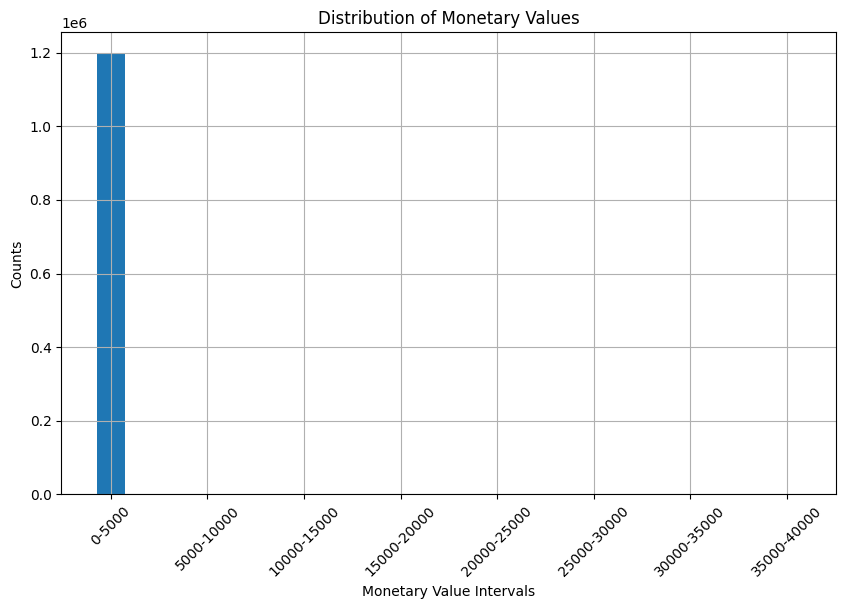

In [63]:
intervals = range(0, 40000, 5000)  
counts = [count_values_in_range(rfm_scores,"Monetary_score",low, low + 5000) for low in intervals]

plt.figure(figsize=(10, 6))
plt.bar(intervals, counts, width=1500) 
plt.title('Distribution of Monetary Values')
plt.xlabel('Monetary Value Intervals')
plt.ylabel('Counts')
plt.xticks(intervals, [f"{intv}-{intv+5000}" for intv in intervals], rotation=45)
plt.grid(True)
plt.show()


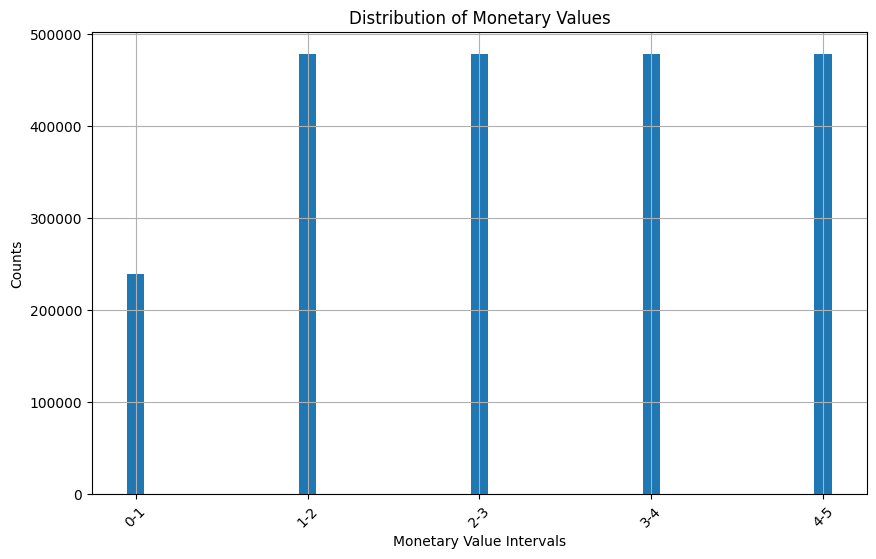

In [64]:
intervals = range(0, 5, 1)  
counts = [count_values_in_range(rfm_scores,"Monetary_score",low, low + 1) for low in intervals]

plt.figure(figsize=(10, 6))
plt.bar(intervals, counts, width=0.1) 
plt.title('Distribution of Monetary Values')
plt.xlabel('Monetary Value Intervals')
plt.ylabel('Counts')
plt.xticks(intervals, [f"{intv}-{intv+1}" for intv in intervals], rotation=45)
plt.grid(True)
plt.show()


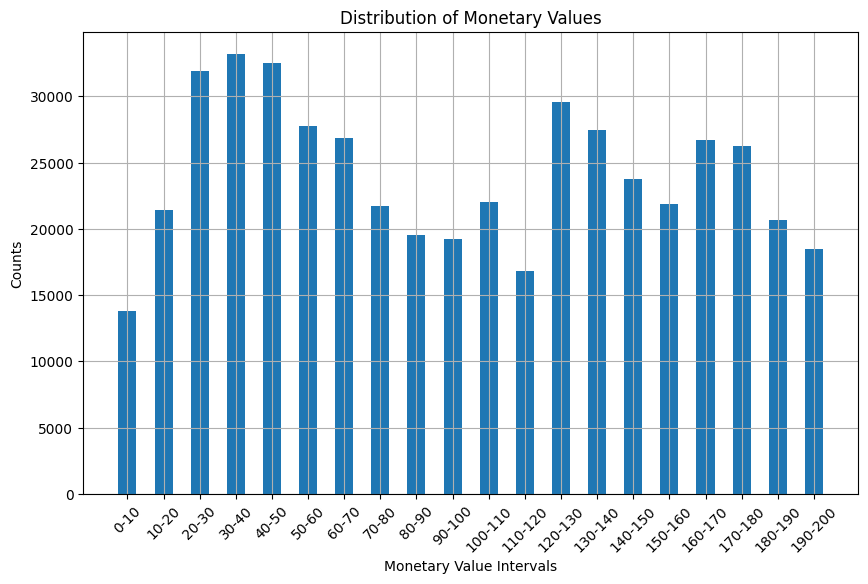

In [34]:
intervals = range(0, 200, 10)  
counts = [count_values_in_range(rfm_table,"Monetary",low, low + 10) for low in intervals]

plt.figure(figsize=(10, 6))
plt.bar(intervals, counts, width=5) 
plt.title('Distribution of Monetary Values')
plt.xlabel('Monetary Value Intervals')
plt.ylabel('Counts')
plt.xticks(intervals, [f"{intv}-{intv+10}" for intv in intervals], rotation=45)
plt.grid(True)
plt.show()


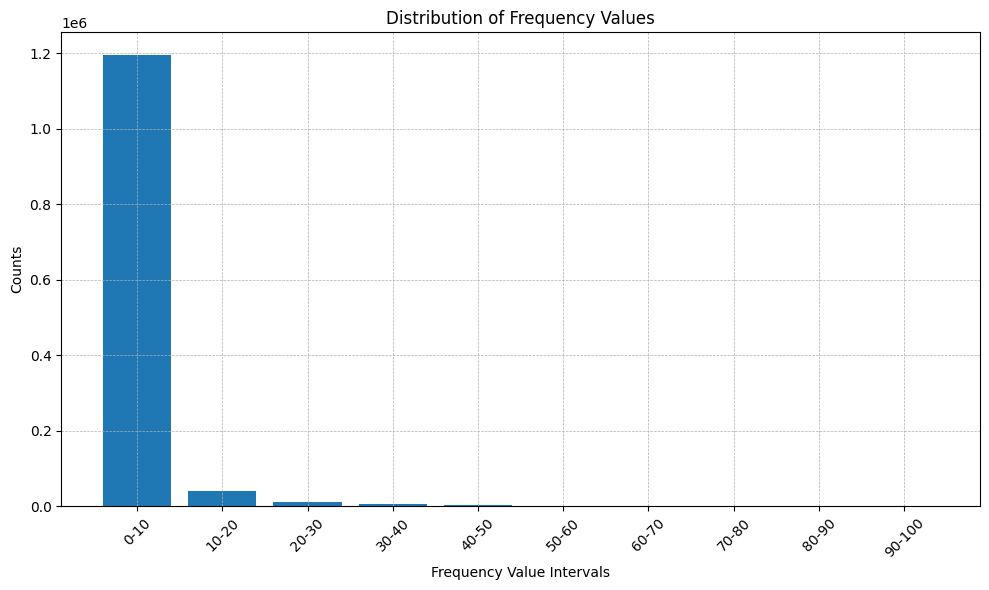

In [35]:
intervals = list(range(0, 100, 10))  
labels = [f"{low}-{low + 10}" for low in intervals] 

counts = [count_values_in_range(rfm_table, "Frequency", low, low + 200) for low in intervals]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, width=0.8)  


plt.title('Distribution of Frequency Values')
plt.xlabel('Frequency Value Intervals')
plt.ylabel('Counts')
plt.xticks(rotation=45)  
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 
plt.tight_layout()
plt.show()


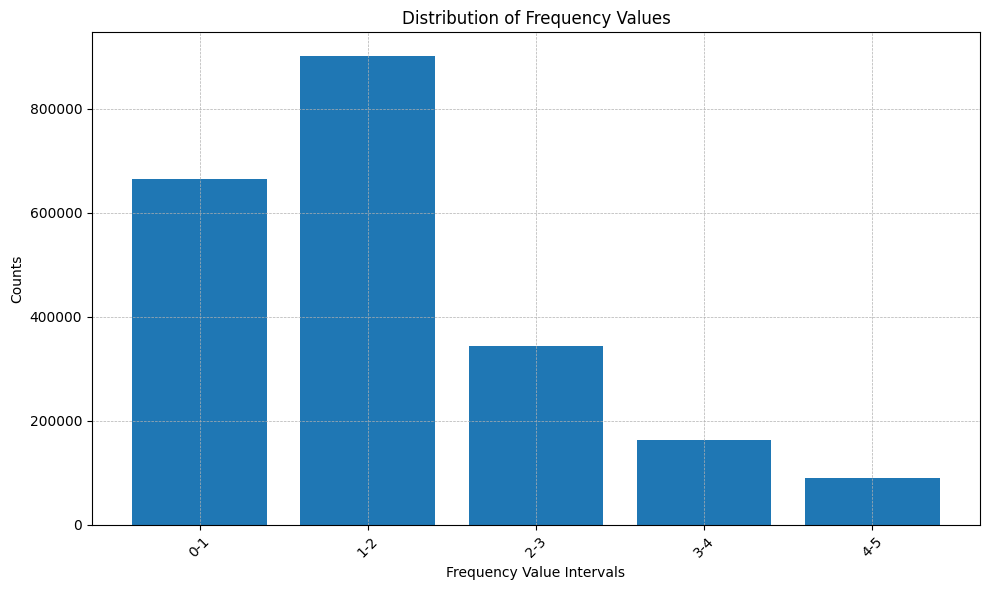

In [66]:
intervals = list(range(0, 5, 1))  
labels = [f"{low}-{low + 1}" for low in intervals] 

counts = [count_values_in_range(rfm_table, "Frequency", low, low + 1) for low in intervals]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, width=0.8)  


plt.title('Distribution of Frequency Values')
plt.xlabel('Frequency Value Intervals')
plt.ylabel('Counts')
plt.xticks(rotation=45)  
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 
plt.tight_layout()
plt.show()


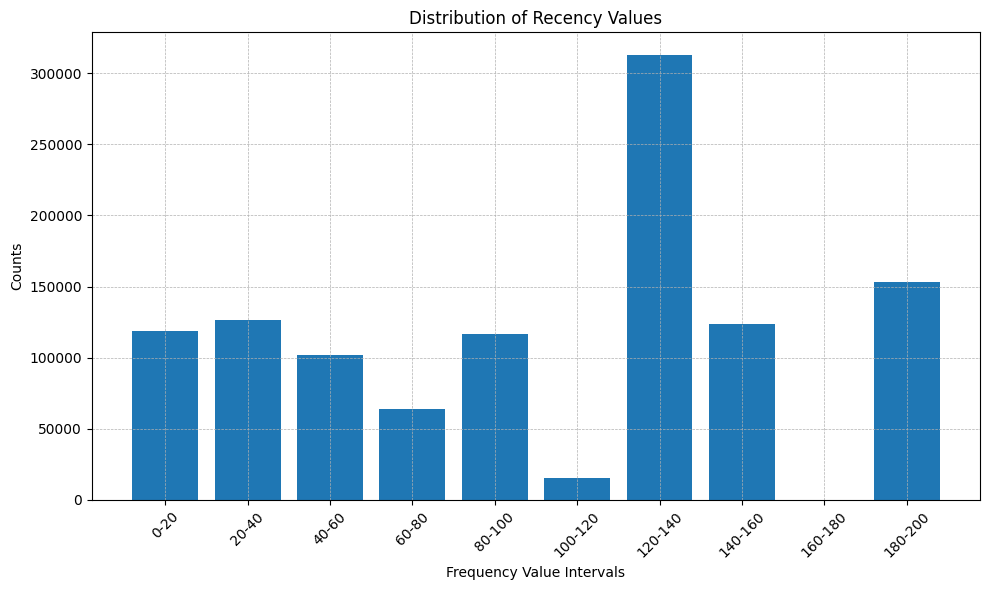

In [36]:
intervals = list(range(0, 200, 20))  
labels = [f"{low}-{low + 20}" for low in intervals] 

counts = [count_values_in_range(rfm_table, "Recency", low, low + 20) for low in intervals]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, width=0.8)  


plt.title('Distribution of Recency Values')
plt.xlabel('Frequency Value Intervals')
plt.ylabel('Counts')
plt.xticks(rotation=45)  
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 
plt.tight_layout()
plt.show()


In [9]:

assembler = VectorAssembler(inputCols=["recency", "frequency", "monetary"], outputCol="features")
rfm_assembled = assembler.transform(rfm_table)

In [6]:
assembler = VectorAssembler(inputCols=["recency_score", "frequency_score", "monetary_score"], outputCol="features")
rfm_assembled = assembler.transform(rfm_scores)

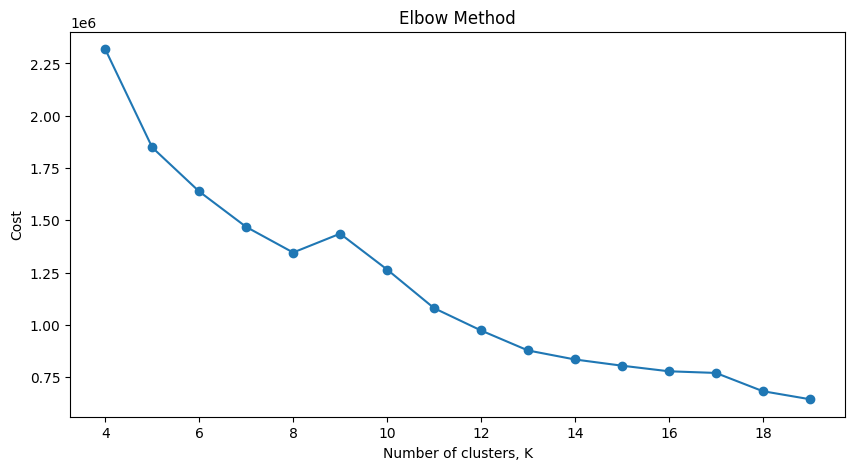

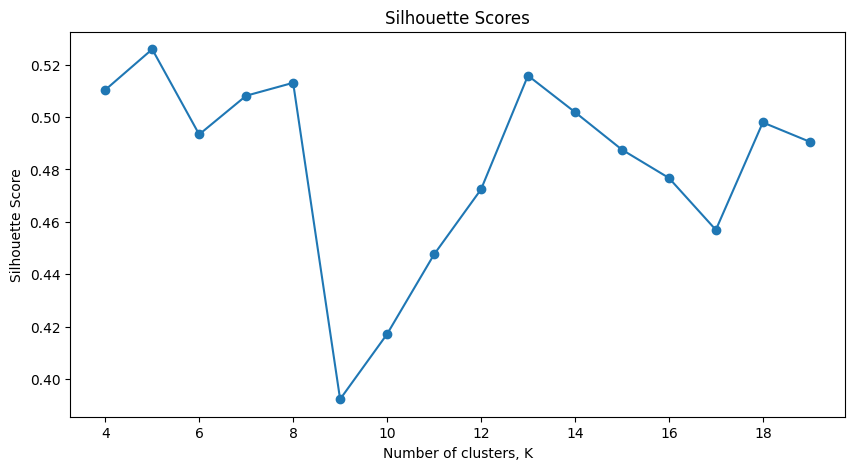

In [28]:






cost = []
silhouette_scores = []

for K in range(4, 20):
    kmeans = KMeans(featuresCol="features", k=K)
    model = kmeans.fit(rfm_assembled)
    predictions = model.transform(rfm_assembled)
    
    cost.append(model.summary.trainingCost)
    
    evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

plt.figure(figsize=(10, 5))
plt.plot(range(4, 20), cost, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters, K')
plt.ylabel('Cost')
plt.show()

# Plot the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range(4, 20), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters, K')
plt.ylabel('Silhouette Score')
plt.show()


In [29]:

    kmeans_f = KMeans(featuresCol="features", k=5)
    model_f = kmeans_f.fit(rfm_assembled)
    predictions_f = model_f.transform(rfm_assembled)
    evaluator_f = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette_score_f = evaluator_f.evaluate(predictions_f)
    print(silhouette_score_f,model_f.summary.trainingCost)
    

0.5258814006167273 1848343.8196904375


In [31]:
# Afficher les centres des clusters
centers = model_f.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

predictions_f.select("features", "prediction").show(10)


Cluster Centers: 
[4.12879228 4.43064805 4.5117696 ]
[3.82679108 1.71318748 1.84483114]
[4.01046585 4.40623364 2.38224046]
[1.4892851  1.598297   1.71300649]
[1.60002433 2.87875532 4.19704439]
+-------------+----------+
|     features|prediction|
+-------------+----------+
|[1.0,1.0,1.0]|         3|
|[1.0,1.0,1.0]|         3|
|[1.0,1.0,1.0]|         3|
|[1.0,1.0,1.0]|         3|
|[4.0,1.0,1.0]|         1|
|[2.0,1.0,1.0]|         3|
|[2.0,1.0,1.0]|         3|
|[1.0,1.0,1.0]|         3|
|[2.0,1.0,1.0]|         3|
|[3.0,1.0,1.0]|         1|
+-------------+----------+
only showing top 10 rows



In [15]:
predictions_f.groupBy('prediction').agg(count('*')).show()

+----------+--------+
|prediction|count(1)|
+----------+--------+
|         1|  237915|
|         3|  238873|
|         4|  246650|
|         2|  200557|
|         0|  271802|
+----------+--------+



In [32]:
predictions_f.show()

+---------+-------------+---------------+--------------+-------------+----------+
|  user_id|recency_score|frequency_score|monetary_score|     features|prediction|
+---------+-------------+---------------+--------------+-------------+----------+
|553431815|            1|              1|             1|[1.0,1.0,1.0]|         3|
|595104624|            1|              1|             1|[1.0,1.0,1.0]|         3|
|569333570|            1|              1|             1|[1.0,1.0,1.0]|         3|
|549109608|            1|              1|             1|[1.0,1.0,1.0]|         3|
|512386086|            4|              1|             1|[4.0,1.0,1.0]|         1|
|513230794|            2|              1|             1|[2.0,1.0,1.0]|         3|
|538216048|            2|              1|             1|[2.0,1.0,1.0]|         3|
|513320236|            1|              1|             1|[1.0,1.0,1.0]|         3|
|568782581|            2|              1|             1|[2.0,1.0,1.0]|         3|
|519267944|     

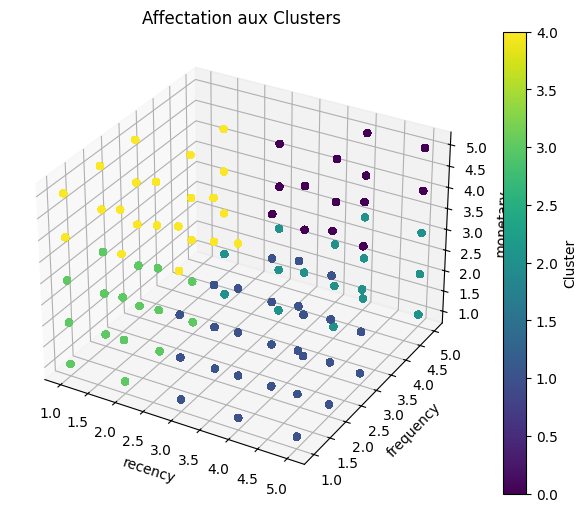

In [40]:

data_collected = predictions_f.select("features", "prediction").collect()

# Extraire les caractéristiques et les prédictions
features = np.array([row['features'] for row in data_collected])
predictions = np.array([row['prediction'] for row in data_collected])

# Tracer
fig = plt.figure(figsize=(8, 6))
if features.shape[1] == 3:
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=predictions, cmap='viridis')
    ax.set_xlabel('recency')
    ax.set_ylabel('frequency')
    ax.set_zlabel('monetary')
else:
    ax = fig.add_subplot(111)
    scatter = ax.scatter(features[:, 0], features[:, 1], c=predictions, cmap='viridis')

plt.colorbar(scatter, ax=ax, label='Cluster')
ax.set_title('Affectation aux Clusters')
plt.show()
